## Experiment Overview
Reward given by reaching target location, with error margin of paddle_height / 2, with a velocity of 0
 - Architectures tried: 
    paddle: relative distance to goal (5 runs with 10 hidden layers, 5 runs with 30 hidden layers, 5 runs with 100 hidden layers) 
    paddle: relative distance to goal, paddle: velocity (5 runs with 10 hidden layers, 5 runs with 30 hidden layers, 5 runs with 100 hidden layers) 
    paddle: relative distance to goal, paddle: velocity, paddle: acceleration (5 runs with 10 hidden layers, 5 runs with 30 hidden layers, 5 runs with 100 hidden layers) 
    (run for 2000 episodes (~200-250k steps) each)
    
    

 - Reward function specifics (at every time step): 
   - Reaching target location with error margin, with a velocity of 0: +2.5
     - Upon receiving reward, new target location is generated by `(int(np.random.random() * 100 + 20))`
   - Up or down action taken: -0.01
   - No-op:  -0.005

#### Note: There is a demo of the controller in action at the bottom of the notebook

## Notes on Results
 - Effects of number of hidden units on training dynamics is not particularly apparent  
 - Surprisingly unstable. Starting with good initial parameters and training (even with a low learning rate) for a while caused performance to plummet  
 - **It is probably worth switching to PPO for later experiments**. It is difficult to make sense of these experiments currently, since it is difficult to attribute causality in performance dynamics to the learning algorithm itself, initialization, or architecture choices 
 - Getting stuck at local minima is especially bad for RL agents, since that leads them to act in such a way that they generate uninteresting/useless training data for themselves
 - There are a good set of weights that I found outside the scope of these experiments:
   It can get good enough to get to wherever needed to return ball, 
   BUT these weights were found through good choice of inputs and random initialization rather than optimization. 
   Trying to optimize these weights resulted in a catastrophic drop in performance 
 - Getting this controller to behave reasonably well took much more effort than I would have imagined

## Future experiments
 - As stated above, switch to PPO
 - Might be worth exploring deeper architectures to see if this can be done better
 - For dealing with initially bad local minima in training, should we reinitialize those with bad initial weights? (while tracking the number of re-initializations)
   - For example, measure the performance of 100 random initializations for some initialization method, set some cutoff based on a percentile, and when training new agents re-initialize the weights if they don’t meet that initial cutoff  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
DIR = './results/'
exp_filenames = sorted([f for f in os.listdir(DIR) if os.path.isfile(DIR+f)])

In [3]:
#exp_filenames

#### The experiment files are organized as follows:
 - The last line contains end - start time
 - The middles lines contain the episode number and the reward gained

In [4]:
## Gather experiment data into lists
exps = []
for filename in exp_filenames:
    with open(DIR+filename) as fp:
        exp = []
        exp.append(filename)
        for line in fp:
            exp.append(line)
        exps.append(exp)

In [5]:
## Organize experiment results into lists including filename, runtime of experiment, and array of results,
## with the first column representing the episode number, and the second column representing the reward received
exp_results = []
for exp in exps:
    results = []
    filename = exp[0]
    time_to_run = float(exp[-1].strip("\n"))
    for i in range(1,len(exp)-1):
        results.append(np.array(list(map(float, exp[i].strip("\n").rsplit(" ")))))
    results = np.array(results)
    exp_results.append([filename, time_to_run, results])

In [6]:
def get_exps_info(exps, num_experiments=5, avg_over=100):
    total_reward = 0
    running_reward = []
    running_means = []
    variances = []
    res_idx = 2
    rwd_idx = 1
    for i in range(num_experiments):
        running_mean = []
        for j in range(len(exps[i][res_idx])):
            total_reward += exps[i][res_idx][j][rwd_idx]
            running_reward.append(total_reward)
            if j >= avg_over and j % avg_over == 0:
                running_mean.append(np.mean(exps[i][res_idx][j-avg_over:j][:,rwd_idx]))
        variances.append(np.var(exps[i][res_idx][:,1]))
        running_means.append(running_mean)
    return running_reward, running_means, variances

In [7]:
def display_timing_info(exps, num_experiments=5):
    fname_idx=0; time_idx=1
    for i in range(num_experiments):
        print(exps[i][fname_idx] + " took an average of {0:.0f} seconds or {1:.1f} minutes to run".format(exps[i][time_idx], exps[i][time_idx]/60))

In [8]:
def plot5(running_reward, running_means, exps):
    plt.figure(figsize=(14,5))
    plt.subplot(121)
    plt.title("Total reward / time")
    plt.plot(range(len(running_reward)), running_reward)
    plt.subplot(122)
    plt.title("Running average reward of previous " + str(avg_over) + " mini-games")
    plt.plot(range(len(running_means[0])), running_means[0], label=exps[0][0])
    plt.plot(range(len(running_means[1])), running_means[1], label=exps[1][0])
    plt.plot(range(len(running_means[2])), running_means[2], label=exps[2][0])
    plt.plot(range(len(running_means[3])), running_means[3], label=exps[3][0])
    plt.plot(range(len(running_means[4])), running_means[4], label=exps[4][0])
    plt.legend()

# Results grouped by experiment type

In [9]:
pos = exp_results[15:30]
pos_vel = exp_results[30:45]
pos_vel_acc = exp_results[0:15]

## Relative positions of the paddle to target location
10, 30, 100 hidden neurons: 5 experiment runs each

### 100 hidden neurons

In [10]:
avg_over = 500
exps = pos[0:5]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

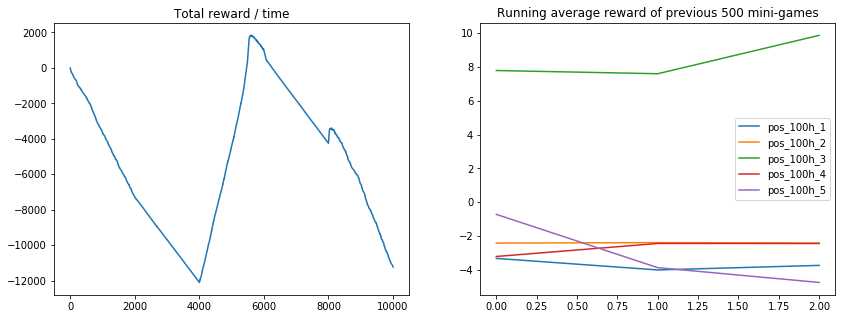

In [11]:
plot5(running_reward, running_means, exps)

In [12]:
display_timing_info(exps)

pos_100h_1 took an average of 5545 seconds or 92.4 minutes to run
pos_100h_2 took an average of 5157 seconds or 85.9 minutes to run
pos_100h_3 took an average of 5239 seconds or 87.3 minutes to run
pos_100h_4 took an average of 5141 seconds or 85.7 minutes to run
pos_100h_5 took an average of 5743 seconds or 95.7 minutes to run


### 10 hidden neurons

In [13]:
avg_over = 500
exps = pos[5:10]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

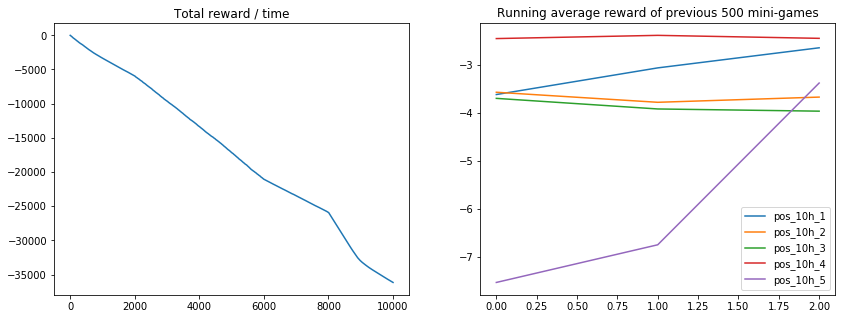

In [14]:
plot5(running_reward, running_means, exps)

In [15]:
display_timing_info(exps)

pos_10h_1 took an average of 4922 seconds or 82.0 minutes to run
pos_10h_2 took an average of 4976 seconds or 82.9 minutes to run
pos_10h_3 took an average of 4996 seconds or 83.3 minutes to run
pos_10h_4 took an average of 5047 seconds or 84.1 minutes to run
pos_10h_5 took an average of 5051 seconds or 84.2 minutes to run


### 30 hidden neurons

In [16]:
avg_over = 500
exps = pos[10:15]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

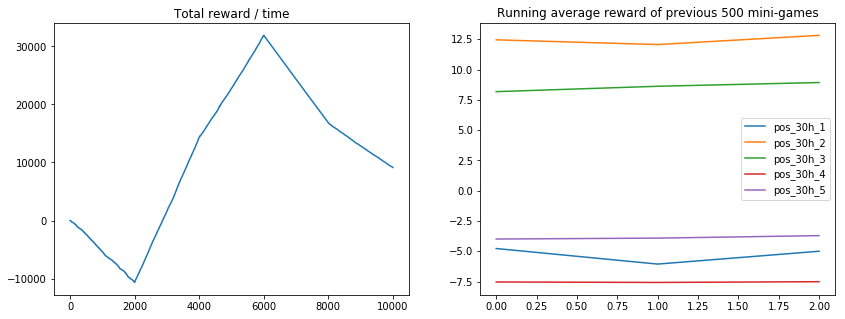

In [17]:
plot5(running_reward, running_means, exps)

In [18]:
display_timing_info(exps)

pos_30h_1 took an average of 6025 seconds or 100.4 minutes to run
pos_30h_2 took an average of 5198 seconds or 86.6 minutes to run
pos_30h_3 took an average of 5209 seconds or 86.8 minutes to run
pos_30h_4 took an average of 5167 seconds or 86.1 minutes to run
pos_30h_5 took an average of 5178 seconds or 86.3 minutes to run


## Relative positions of the paddle to target location, and velocity of the paddle
10, 30, 100 hidden neurons: 5 experiment runs each

### 100 hidden neurons

In [19]:
avg_over = 500
exps = pos_vel[0:5]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

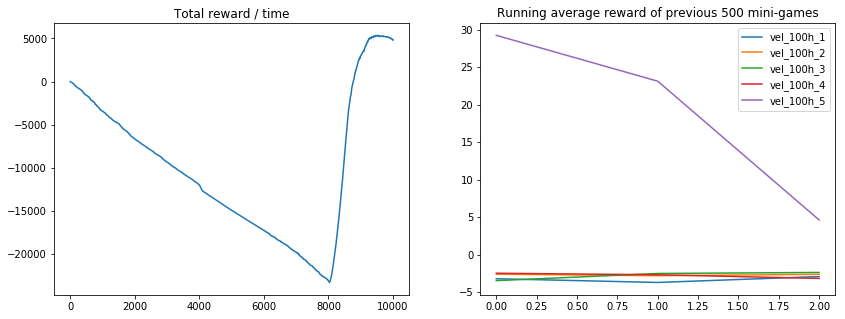

In [20]:
plot5(running_reward, running_means, exps)

In [21]:
display_timing_info(exps)

vel_100h_1 took an average of 5493 seconds or 91.5 minutes to run
vel_100h_2 took an average of 5239 seconds or 87.3 minutes to run
vel_100h_3 took an average of 5123 seconds or 85.4 minutes to run
vel_100h_4 took an average of 5447 seconds or 90.8 minutes to run
vel_100h_5 took an average of 5409 seconds or 90.2 minutes to run


### 10 hidden neurons

In [22]:
avg_over = 500
exps = pos_vel[5:10]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

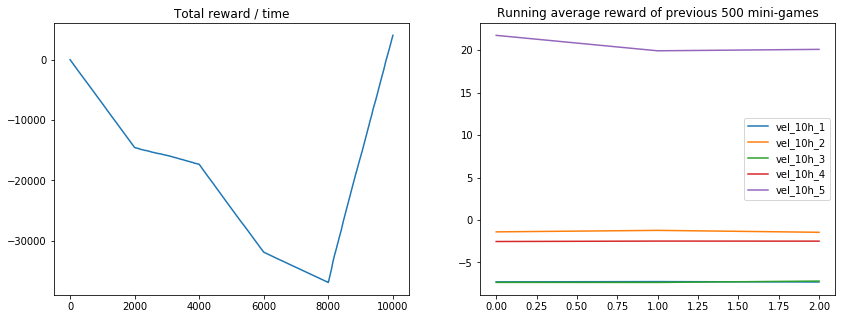

In [23]:
plot5(running_reward, running_means, exps)

In [24]:
display_timing_info(exps)

vel_10h_1 took an average of 4502 seconds or 75.0 minutes to run
vel_10h_2 took an average of 4596 seconds or 76.6 minutes to run
vel_10h_3 took an average of 4607 seconds or 76.8 minutes to run
vel_10h_4 took an average of 4556 seconds or 75.9 minutes to run
vel_10h_5 took an average of 5031 seconds or 83.8 minutes to run


### 30 hidden neurons

In [25]:
avg_over = 500
exps = pos_vel[10:15]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

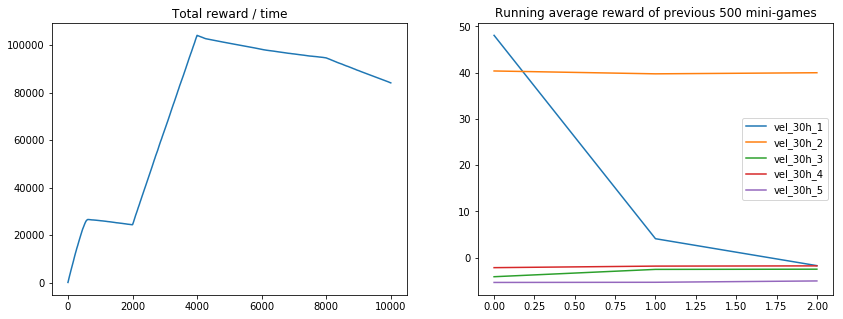

In [26]:
plot5(running_reward, running_means, exps)

In [27]:
display_timing_info(exps)

vel_30h_1 took an average of 5230 seconds or 87.2 minutes to run
vel_30h_2 took an average of 5250 seconds or 87.5 minutes to run
vel_30h_3 took an average of 5206 seconds or 86.8 minutes to run
vel_30h_4 took an average of 5114 seconds or 85.2 minutes to run
vel_30h_5 took an average of 5137 seconds or 85.6 minutes to run


## Relative positions of the paddle to target location, and velocity of the paddle, and the acceleration of the paddle
10, 30, 100 hidden neurons: 5 experiment runs each

### 100 hidden neurons

In [28]:
avg_over = 500
exps = pos_vel_acc[0:5]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

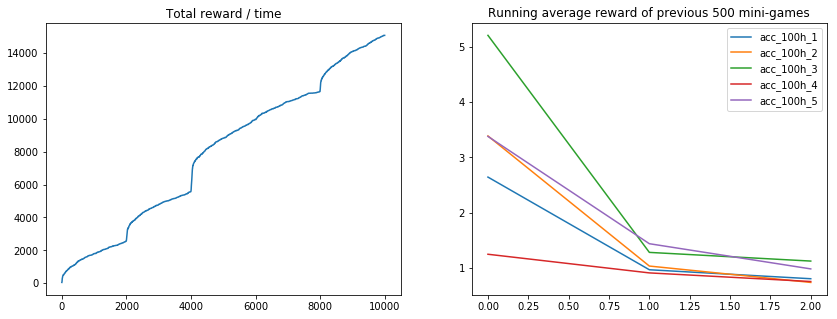

In [29]:
plot5(running_reward, running_means, exps)

In [30]:
display_timing_info(exps)

acc_100h_1 took an average of 5532 seconds or 92.2 minutes to run
acc_100h_2 took an average of 5508 seconds or 91.8 minutes to run
acc_100h_3 took an average of 5555 seconds or 92.6 minutes to run
acc_100h_4 took an average of 5509 seconds or 91.8 minutes to run
acc_100h_5 took an average of 5579 seconds or 93.0 minutes to run


### 10 hidden neurons

In [31]:
avg_over = 500
exps = pos_vel_acc[5:10]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

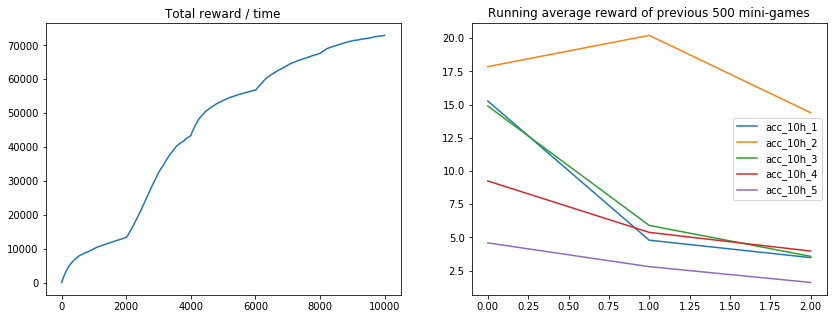

In [32]:
plot5(running_reward, running_means, exps)

In [33]:
display_timing_info(exps)

acc_10h_1 took an average of 5736 seconds or 95.6 minutes to run
acc_10h_2 took an average of 5818 seconds or 97.0 minutes to run
acc_10h_3 took an average of 5706 seconds or 95.1 minutes to run
acc_10h_4 took an average of 5739 seconds or 95.6 minutes to run
acc_10h_5 took an average of 5422 seconds or 90.4 minutes to run


### 30 hidden neurons

In [34]:
avg_over = 500
exps = pos_vel_acc[10:15]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

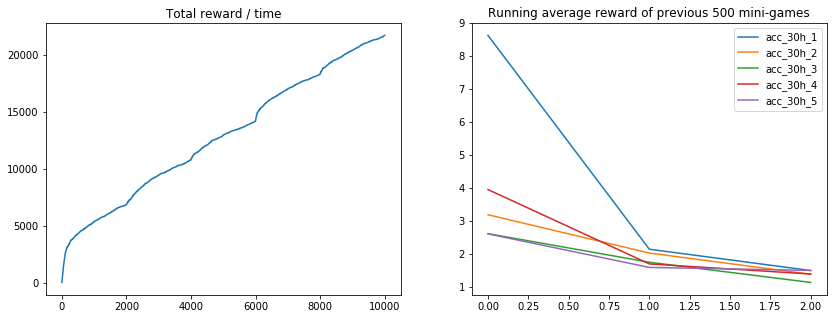

In [35]:
plot5(running_reward, running_means, exps)

In [36]:
display_timing_info(exps)

acc_30h_1 took an average of 5639 seconds or 94.0 minutes to run
acc_30h_2 took an average of 5650 seconds or 94.2 minutes to run
acc_30h_3 took an average of 5596 seconds or 93.3 minutes to run
acc_30h_4 took an average of 5604 seconds or 93.4 minutes to run
acc_30h_5 took an average of 5600 seconds or 93.3 minutes to run


## Demo
 - OpenAI gym required: `pip install gym[atari]`
 - These are a good set of weights I found outside the scope of these experiments (for position + velocity model with 20 hidden units)
 - It can get good enough to get to wherever needed to return ball in time to return a volley that would have gone to that location(most of the time), BUT good weights were found through good choice of inputs and random initialization rather than optimization

In [62]:
import gym
import time

In [58]:
H = 20 # number of hidden layer neurons
paddle_height = 15
D = 2 ## 1. (where we are - where we need to go), 2. (paddle center last frame - paddle center this frame)
n_actions = 3

w1 = np.loadtxt('W1.weights', dtype=float)
w2 = np.loadtxt('W2.weights', dtype=float)

model = {'W2': w2, 'W1':w1}

In [59]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def stable_softmax(X):
    exps = np.exp(X - np.max(X))
    return exps / np.sum(exps)

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I = I[:-1,:,0]
    return I.astype(np.float)

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(h, model['W2'])
    p = stable_softmax(logp)
    return p, h # return probability of taking actions, and hidden state

def get_paddle_y(img, display_message=False):
    paddle_2_x = 139 # Leftmost position of paddle 2
    paddle_height = 15

    paddle_1_color = 213
    paddle_2_color = 92
    ball_color = 236

    ## In the beginning of the game, the paddle on the left and the ball are not yet present
    not_all_present = np.where(img == paddle_2_color)[0].size == 0
    if (not_all_present):
        if display_message:
            print("One or more of the objects is missing, returning an empty list of positions")
            print("(This happens at the first few steps of the game)")
        return -1

    paddle_2_top = np.unique(np.where(img == paddle_2_color)[0])[0]
    paddle_2_bot = paddle_2_top + paddle_height

    return (paddle_2_top + paddle_2_bot) / 2

In [60]:
render=True
delay=True

In [65]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
reward_sum = 0
episode_number = 0

## Actions
action_up = 2
action_down = 5
action_nop = 0
actions = [action_up, action_down, action_nop]

observation = env.reset()

prev_paddle_y = -1
target_loc = 55
up_down_counter = 0
no_op_counter = 0
steps = 0

while(episode_number < 10):
    if render: 
        env.render()
        if delay: time.sleep(0.25)

    # preprocess the observation
    curr_img = prepro(observation)
    paddle_y = get_paddle_y(curr_img)

    if paddle_y != -1 and prev_paddle_y != -1:
        vel = paddle_y - prev_paddle_y
        x = np.array([target_loc - paddle_y, vel])
    else:
        vel = 0
        x = np.zeros(D)

    # forward the policy network and sample an action from the returned probability
    aprobs, h = policy_forward(x)
    action_idx = np.random.choice(n_actions, p=aprobs)
    action = actions[action_idx]
    y = np.zeros(n_actions)
    y[action_idx] = 1 # action taken

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    steps += 1

    ## ~~~~~~~~~~~~~~~~~~
    ## Reward Assignment
    ## ~~~~~~~~~~~~~~~~~~
    if paddle_y == -1:
        reward = 0
    elif np.abs(x[0]) < (paddle_height / 2) and vel == 0:
        reward = 2.5
        target_loc = int(np.random.random() * 100 + 20)
        print("reward achieved, new target location: " + str(target_loc))
    elif action == action_up or action == action_up:
        reward = -.01
        up_down_counter += 1
    else: # punish no-ops less
        reward = -.01 / 2
        no_op_counter += 1

    reward_sum += reward
    prev_paddle_y = paddle_y

    if done: # an episode finished
        print("Total reward for this ep({0:d}): ".format(episode_number) + str(reward_sum))
        episode_number += 1
        print("This epsiode lasted " + str(steps) + " steps")
        steps = 0
        reward_sum = 0

reward achieved, new target location: 31
reward achieved, new target location: 93
reward achieved, new target location: 116
reward achieved, new target location: 83
reward achieved, new target location: 90
reward achieved, new target location: 60
reward achieved, new target location: 110
reward achieved, new target location: 47
reward achieved, new target location: 111
reward achieved, new target location: 43
reward achieved, new target location: 53
reward achieved, new target location: 77
reward achieved, new target location: 106
reward achieved, new target location: 113
reward achieved, new target location: 57
reward achieved, new target location: 22
reward achieved, new target location: 22
reward achieved, new target location: 29
reward achieved, new target location: 41
reward achieved, new target location: 28
reward achieved, new target location: 26
reward achieved, new target location: 96
reward achieved, new target location: 48
reward achieved, new target location: 52
reward achi

KeyboardInterrupt: 